<a href="https://colab.research.google.com/github/SuperTonik/Hobby/blob/main/cnn_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Feed-forward neural network (FNN) is a type of artificial neural network. FNN consists of input layer which is followed by hidden layers and then an output layer. Data flows from the input layer through the hidden layers making it a uni-directional network.

The hidden layer of the FNN consists of nodes. These individual notes have activation functions which govern the node's output given some input and a weight. An example of an activation function is the popular rectified linear unit (ReLu).

$f(x) = max(0, x) = \frac{x + |x|}{2} = \begin{cases} x, & \text{if}\; x > 0, \\ 0 & \text{otherwise.}\end{cases}$

Earliest and most simple FNN was actually used by Legendre and Gauss in early 19th century to predict planetary movement.

The problem with FNN is that even small inputs require many weights for a each node. The number of weight per node can be reduced with convolution.

## Convolution
Convolution itself is a pretty hefty topic. In mathematical terms convolution of functions $f$ and $g$ is
$ (f * g)(t) := \int_{-\infty}^{\infty} f(t-\tau)g(\tau)d\tau.$

As a very simple example, we consider two sets $a = \{2, 4, 6\}$ and $b = \{1,2,3\}$. The convolution of this is calculated as

$ (a*b) = \{2*1, 2*2+4*1, 3*2+2*4+1*6, 3*4+2*6, 3*6\} = \{2, 8, 20, 24, 18\}.$

This can be verified using NumPy.

In [3]:
import numpy as np

a = np.array([2, 4, 6])
b = np.array([1, 2, 3])

print(np.convolve(a, b))

[ 2  8 20 24 18]


Convolution is used in image processing. For example, Gaussian blur calculates the pixel values using convolution from surrounding pixels. The surrounding pixels refers the kernel used in the method. In Gaussian blur, the kernel is constructed by sampling values from Gaussian distribution, i. e. the center of the kernel has largest value and then the values drop following the distribution. Here is an example of Gaussian kernel which can be generated quite easily:

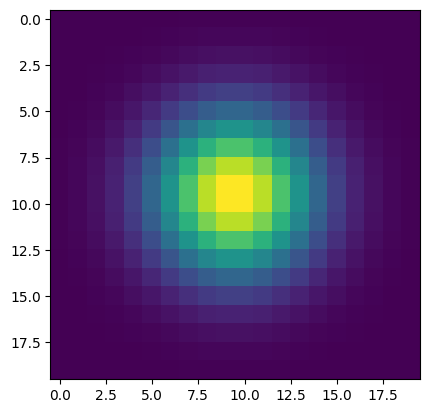

In [4]:
import matplotlib.pyplot as plt

def gaussian_kernel(l, sig):
    """
      Generates a 2D Gaussian kernel with side length of 'l' and sigma of 'sig'.
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

kernel = gaussian_kernel(20, 3)

plt.imshow(kernel)
plt.show()

## Convolution in neural networks

Convolutional neural networks have convolutional layers (and also regular hidden layers). Convolutional layers are such hidden layer in which the transformation of input is a convolution operation. These convolutional layer have kernels similarly to the above mentioned example.

# Loading up the images

For this case study, I'm going to use MRI scans of brain tumors from Kaggle.

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")
print("Path to dataset files:", path)

100%|██████████| 236M/236M [00:02<00:00, 118MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1


In [97]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
import torchvision
from albumentations.pytorch import ToTensorV2
from torch.optim import lr_scheduler
from torchvision import datasets
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, random_split
from PIL import Image

# Prefer to use CUDA. In Colab, set T4/GPU from the options.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


The PyTorch models are pretrained. For this reason, the data must be preprocessed correctly, otherwise the accuracy will be bad or even faulty. The preprocessing is done for each image by first loading the transform attribute from the selected weights and applying it to the image. The same preprocessing can also be applied when predicting an actual image.

In [7]:
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

class CustomImageDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageDataset, self).__init__(root, transform=None)

    def __getitem__(self, index):
        image, label = super(CustomImageDataset, self).__getitem__(index)
        image = preprocess(image)
        return image, label

dataset = CustomImageDataset(path)

train_size = int(0.7 * len(dataset))    # Training dataset size is 70 %
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Let's plot some examples of the dataset for each different case of image.

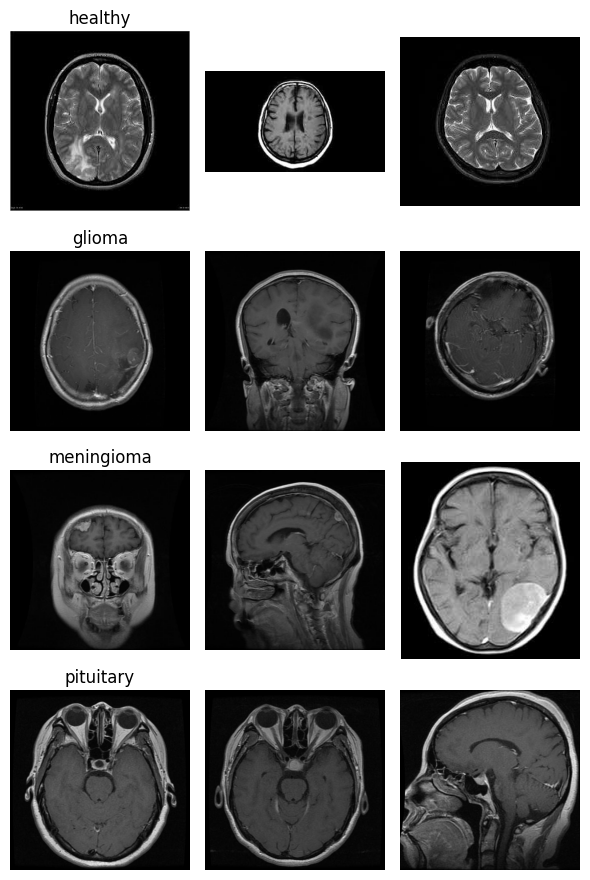

In [8]:
import random

classes = ['healthy', 'glioma', 'meningioma', 'pituitary']

fig, axs = plt.subplots(len(classes), 3, figsize=(6, 9))
for i, class_name in enumerate(classes):
    dir = os.path.join(path, class_name)
    images = random.sample(os.listdir(dir), 3)
    for j, image_name in enumerate(images):
        img = Image.open(os.path.join(dir, image_name))
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(class_name)
plt.tight_layout()
plt.show()

# Training the model
[ResNet50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html) is a type of CNN that is widely used in image predictions. As previously mentioned, the ResNet50 implementation in PyTorch comes with pretrained weights which I'm going to use in this demo.

Criterion defines when the algorithm for the optimizer should stop. [Cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) is suited for this case because we are training a classification problem with $C$ classes.

The architure type here is called deep feature extraction as described by [Castiglioni et al](https://doi.org/10.1016/j.ejmp.2021.02.006). The ResNet50 is a pretrained model which performs feature extraction and the model is then fine tuned.

The training is done in epochs. During an epoch, the whole training dataset is passed throught and the model updated accordingly. The weights of are updated according to the loss function. The number of epochs matters; more epochs can lead to overfitting.

In [9]:
model = resnet50(weights=weights)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    val_loss, val_acc = evaluate_model(model, val_loader, criterion)
    scheduler.step(val_loss)

    print("Train Loss: {}, Val Loss: {}, Val Acc: {}".format((running_loss/len(train_loader)), val_loss, val_acc))
    history['train_loss'].append(running_loss/len(train_loader))
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_acc > best_acc:
      best_acc = val_acc
      best_model_wts = copy.deepcopy(model.state_dict())

  model.load_state_dict(best_model_wts)
  return model, history

def evaluate_model(model, data_loader, criterion):
  model.eval()
  running_loss = 0.0
  running_corrects = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)
      running_loss += loss.item()
      running_corrects += (preds == labels).sum().item()
      total += labels.size(0)

  return running_loss / len(data_loader), 100 * running_corrects / total


In [11]:
num_epochs = 5
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

Epoch 1/5
Train Loss: 0.3031821116901837, Val Loss: 0.6898469860580835, Val Acc: 81.90883190883191
Epoch 2/5
Train Loss: 0.16778656000924574, Val Loss: 0.20253681112080812, Val Acc: 92.3076923076923
Epoch 3/5
Train Loss: 0.09161626953667924, Val Loss: 0.21208295310762795, Val Acc: 93.01994301994301
Epoch 4/5
Train Loss: 0.06608186561505419, Val Loss: 0.14441208592192692, Val Acc: 94.72934472934473
Epoch 5/5
Train Loss: 0.05941032769699738, Val Loss: 0.33023509112271393, Val Acc: 90.31339031339031


# Results

In [101]:
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print("Test Loss: {:.4}, Test Acc: {:.4}%".format(test_loss, test_acc))

Test Loss: 0.1397, Test Acc: 95.73%


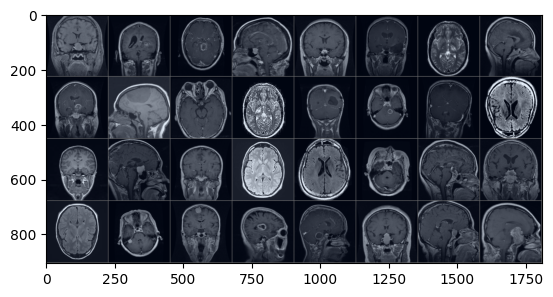

GroundTruth:  pituitary healthy healthy pituitary pituitary healthy glioma healthy healthy meningioma pituitary glioma healthy healthy healthy glioma glioma meningioma healthy glioma glioma pituitary pituitary pituitary glioma meningioma meningioma healthy healthy pituitary pituitary pituitary


In [105]:
def imshow(img):
    npimg = img.numpy()
    npimg = (npimg - np.min(npimg)) / (np.max(npimg) - np.min(npimg))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [117]:
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

print("Correct --->Predicted")
for i in range(batch_size):
  print(f"{classes[labels[i]]} ---> {classes[predicted[i]]}")

Correct --->Predicted
pituitary ---> pituitary
healthy ---> healthy
healthy ---> healthy
pituitary ---> pituitary
pituitary ---> pituitary
healthy ---> healthy
glioma ---> glioma
healthy ---> healthy
healthy ---> healthy
meningioma ---> meningioma
pituitary ---> pituitary
glioma ---> glioma
healthy ---> healthy
healthy ---> healthy
healthy ---> healthy
glioma ---> glioma
glioma ---> glioma
meningioma ---> meningioma
healthy ---> healthy
glioma ---> glioma
glioma ---> glioma
pituitary ---> pituitary
pituitary ---> healthy
pituitary ---> pituitary
glioma ---> glioma
meningioma ---> meningioma
meningioma ---> meningioma
healthy ---> healthy
healthy ---> healthy
pituitary ---> pituitary
pituitary ---> pituitary
pituitary ---> pituitary
